In [53]:
# packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import shap
import scipy.stats as stats
# import xgboost

from scipy.stats import shapiro
from statsmodels.stats import stattools as stools

from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [54]:
# data sets
current = pd.read_csv('2019-first-round-picks.csv')
historical = pd.read_csv('historical-nbafirstround-college-stats.csv')

In [55]:
# features and output
features = ['Pick', 'eFG%', 'FT%', 'PTS', 'SOS', '3PAr', 'FTr']
output = ['NBA-PPG']
historical = historical.dropna(subset=features)

train, test = train_test_split(historical, test_size = 0.25, random_state = 36)
xtrain = train[features]
ytrain = train[output]
xtest = test[features]
ytest = test[output]

In [56]:
# train and evaluate model

def scores(x):
    x.fit(xtrain, ytrain.values.ravel())
    y_pred = x.predict(xtest)
    cv_score = cross_val_score(x, xtest, ytest.values.ravel(), cv = 5, scoring = 'r2')
    y_results = []
    for i in y_pred:
        y_results.append(i)
    
    print("Mean Squared Error: %0.3f" % mean_squared_error(ytest, y_pred))
    print("R2 Score: %0.3f" % r2_score(ytest, y_pred))
    print ("R2 Cross Validation Score: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std()*2 ))
    
    return(y_results)

In [57]:
def residuals(x):
    residual = [i for i in (ytest['NBA-PPG']-x) ]
    sumsquaredresiduals = [i**2 for i in residual]
    
    total_sumsquaredresiduals = 0
    for i in sumsquaredresiduals:
        total_sumsquaredresiduals += i
    
    standard_residual = []
    for i in residual:
        standard_residual.append(i / ((total_sumsquaredresiduals / (ytest.shape[0] - 2)) ** 0.5))
        
    residual_list = []
    for i in standard_residual:
            residual_list.append(i)
            
    return residual_list

In [58]:
def outliers(x):
    np_list = np.array(x)
    stddev = np.std(np_list)
    mean = np.mean(np_list)
    
    number_outliers = 0
    for i in x:
        if i > abs(mean - 2*stddev):
            number_outliers += 1
            
    percentage_outliers = number_outliers / ytest.shape[0]
    string_outlier = "{:0.3%}".format(percentage_outliers)
    
    return string_outlier

In [59]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 25, weights = 'uniform')
y_knn = scores(knn)
knn_residual = residuals(y_knn)

Mean Squared Error: 11.742
R2 Score: 0.508
R2 Cross Validation Score: 0.41 (+/- 0.23)


No handles with labels found to put in legend.


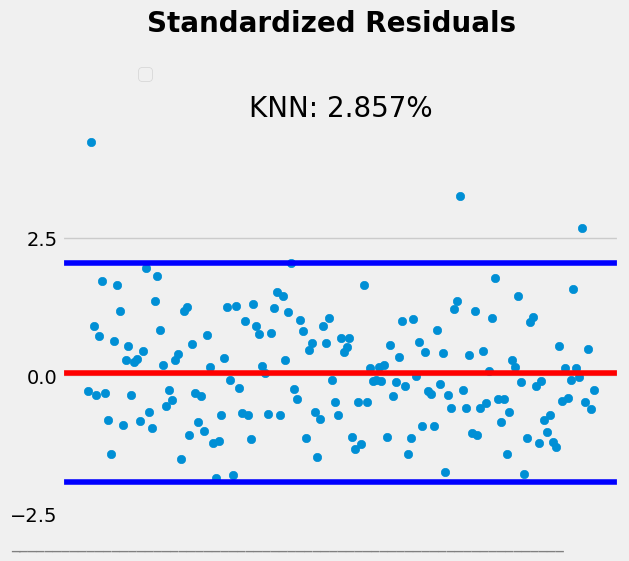

In [60]:
# standardized residual plot
plt.style.use('fivethirtyeight')
residual_figure, ((ax1)) = plt.subplots(1, 1, sharey = 'row')

x = np.arange(ytest.shape[0])
ax1.xaxis.set_visible(False)

ax1.scatter(x, knn_residual)
ax1.axhline(y = np.mean(knn_residual), color = 'red')
ax1.axhline(y = np.mean(knn_residual) - 2*np.std(knn_residual), color = 'blue')
ax1.axhline(y = np.mean(knn_residual) + 2*np.std(knn_residual), color = 'blue')
ax1.set_title("KNN: %s" % outliers(knn_residual), size = 20, x = 0.50, ha='center')

residual_figure.legend(loc = (0.22, 0.855), ncol = 2, prop = {'size': 12, "family": "Rockwell"})
residual_figure.suptitle("Standardized Residuals", weight = 'bold', size = 20, y = 1.12)
ax1.yaxis.set_ticks([-2.5, 0, 2.5])
residual_figure.text(x = 0, y = 0,
                     s = '__________________________________________________________________',
                     fontsize = 12, color = 'grey', horizontalalignment = 'left')
residual_figure.savefig('residual_figure.png', dpi = 300, bbox_inches = 'tight')

In [61]:
#Shapiro-Wilk Test
print(shapiro(knn_residual))

(0.969845712184906, 0.0007576795760542154)


In [62]:
current_prediction = current[features]

def predict(model):
    y_pred = model.predict(current_prediction)
    for i, j in zip(current['Player'], y_pred):
        print(i, j)
    return y_pred

In [63]:
# function to make bar graph from predictions

def make_plot(pred_list, player_list, height, model_name, x_pos, file_name):
    
    plt.style.use('fivethirtyeight')
    
    fig, ax = plt.subplots()
    
    x = range(len(pred_list))
    
    ax.bar(x, pred_list, width = .7, edgecolor = 'white', color = 'aqua', linewidth = 4, label = 'Predicted')

    labels = player_list

    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = height
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')

    if(model_name == 'Average'):
        fig.suptitle("%s projected 2019-20 rookies PPG" % model_name, weight = 'bold', size = 18)
    else:
        fig.suptitle("%s projected 2019-20 rookies PPG" % model_name.upper(), weight = 'bold', size = 18)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("PPG")

    fig.text(x = x_pos, y = 0.03,
        s = '_______________________________________________________________',
        fontsize = 14, color = 'grey', horizontalalignment='left')

    fig.text(x = x_pos, y = -.03,
        s = 'https://steve-cao.com',
        fontsize = 14, fontname = 'Arial', color = 'grey', horizontalalignment='left')

    fig.savefig('%s.png' % file_name, dpi = 400, bbox_inches = 'tight')

In [64]:
knn_prediction = predict(knn)

Zion Williamson 15.276
Ja Morant 10.912
R.J. Barrett 14.099999999999998
DeAndre Hunter 10.184
Darius Garland 10.024000000000001
Jarrett Culver 10.064
Coby White 10.128
Jaxson Hayes 7.627999999999999
Rui Hachimura 6.08
Cameron Reddish 6.535999999999999
Cameron Johnson 5.443999999999999
P.J. Washington 6.696000000000001
Tyler Herro 5.94
Romeo Langford 5.724
Chuma Okeke 4.936
Nickeil Alexander-Walker 5.8599999999999985
Mattise Thybulle 3.98
Brandon Clarke 5.1080000000000005
Grant Williams 5.144
Ty Jerome 3.78
Nassir Little 4.0680000000000005
D. Windler 4.4239999999999995
Mfiondu Kabengele 4.26
Jordan Poole 4.112
Keldon Johnson 4.756
Kevin Porter Jr. 4.620000000000001


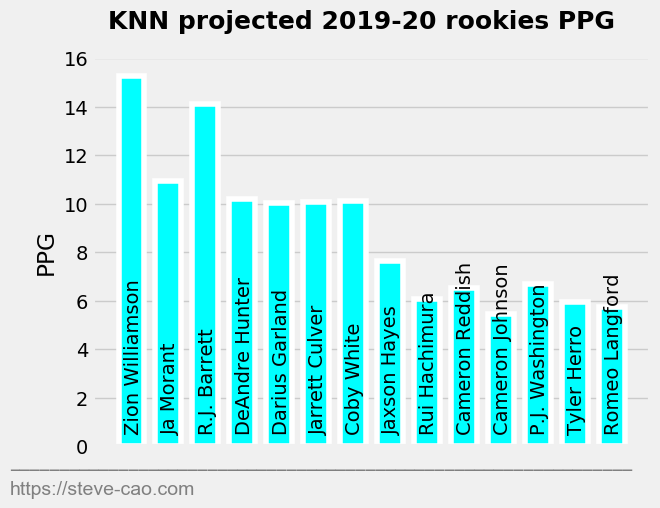

In [65]:
make_plot(knn_prediction[0:14], current['Player'][0:14], .5, 'knn', -0.05, 'knn_1')

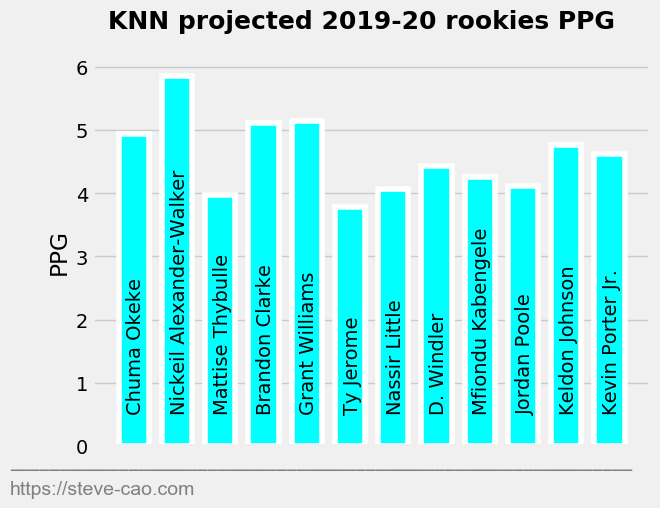

In [66]:
make_plot(knn_prediction[14:], current['Player'][14:], .5, 'knn', -0.05, 'knn_1')

In [67]:
# prepare shap plots

shap.initjs()
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/anaconda3/li

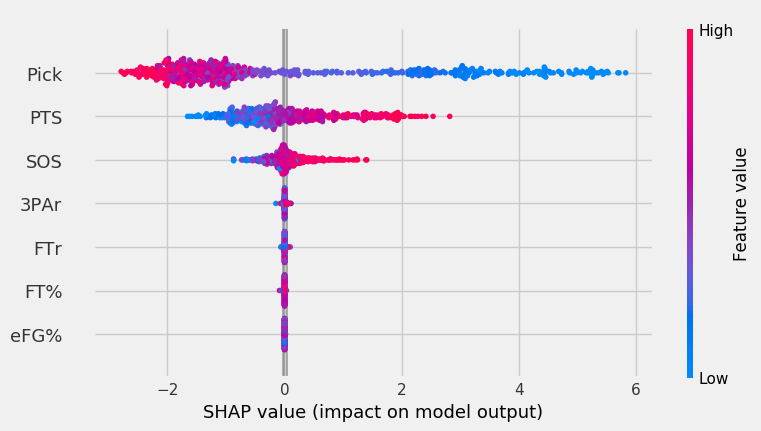

In [68]:
knn_k = shap.kmeans(xtrain, 5)

explainer = shap.KernelExplainer(knn.predict, knn_k)
shap_values = explainer.shap_values(xtrain)

shap.summary_plot(shap_values, xtrain)